C:\Users\linke\AppData\Local\Temp\ipykernel_7508\1234052910.py:159: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ts   = pd.read_sql(SQL_TS,       conn)
C:\Users\linke\AppData\Local\Temp\ipykernel_7508\1234052910.py:160: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_snap = pd.read_sql(SQL_SNAPSHOT, conn)


Saved: C:\Users\linke\OneDrive - AL-Hussien bin Abdullah Technical University\Desktop\Current research\Data Analytics portfolio\Covid\Covid_19_dashboard.jpg


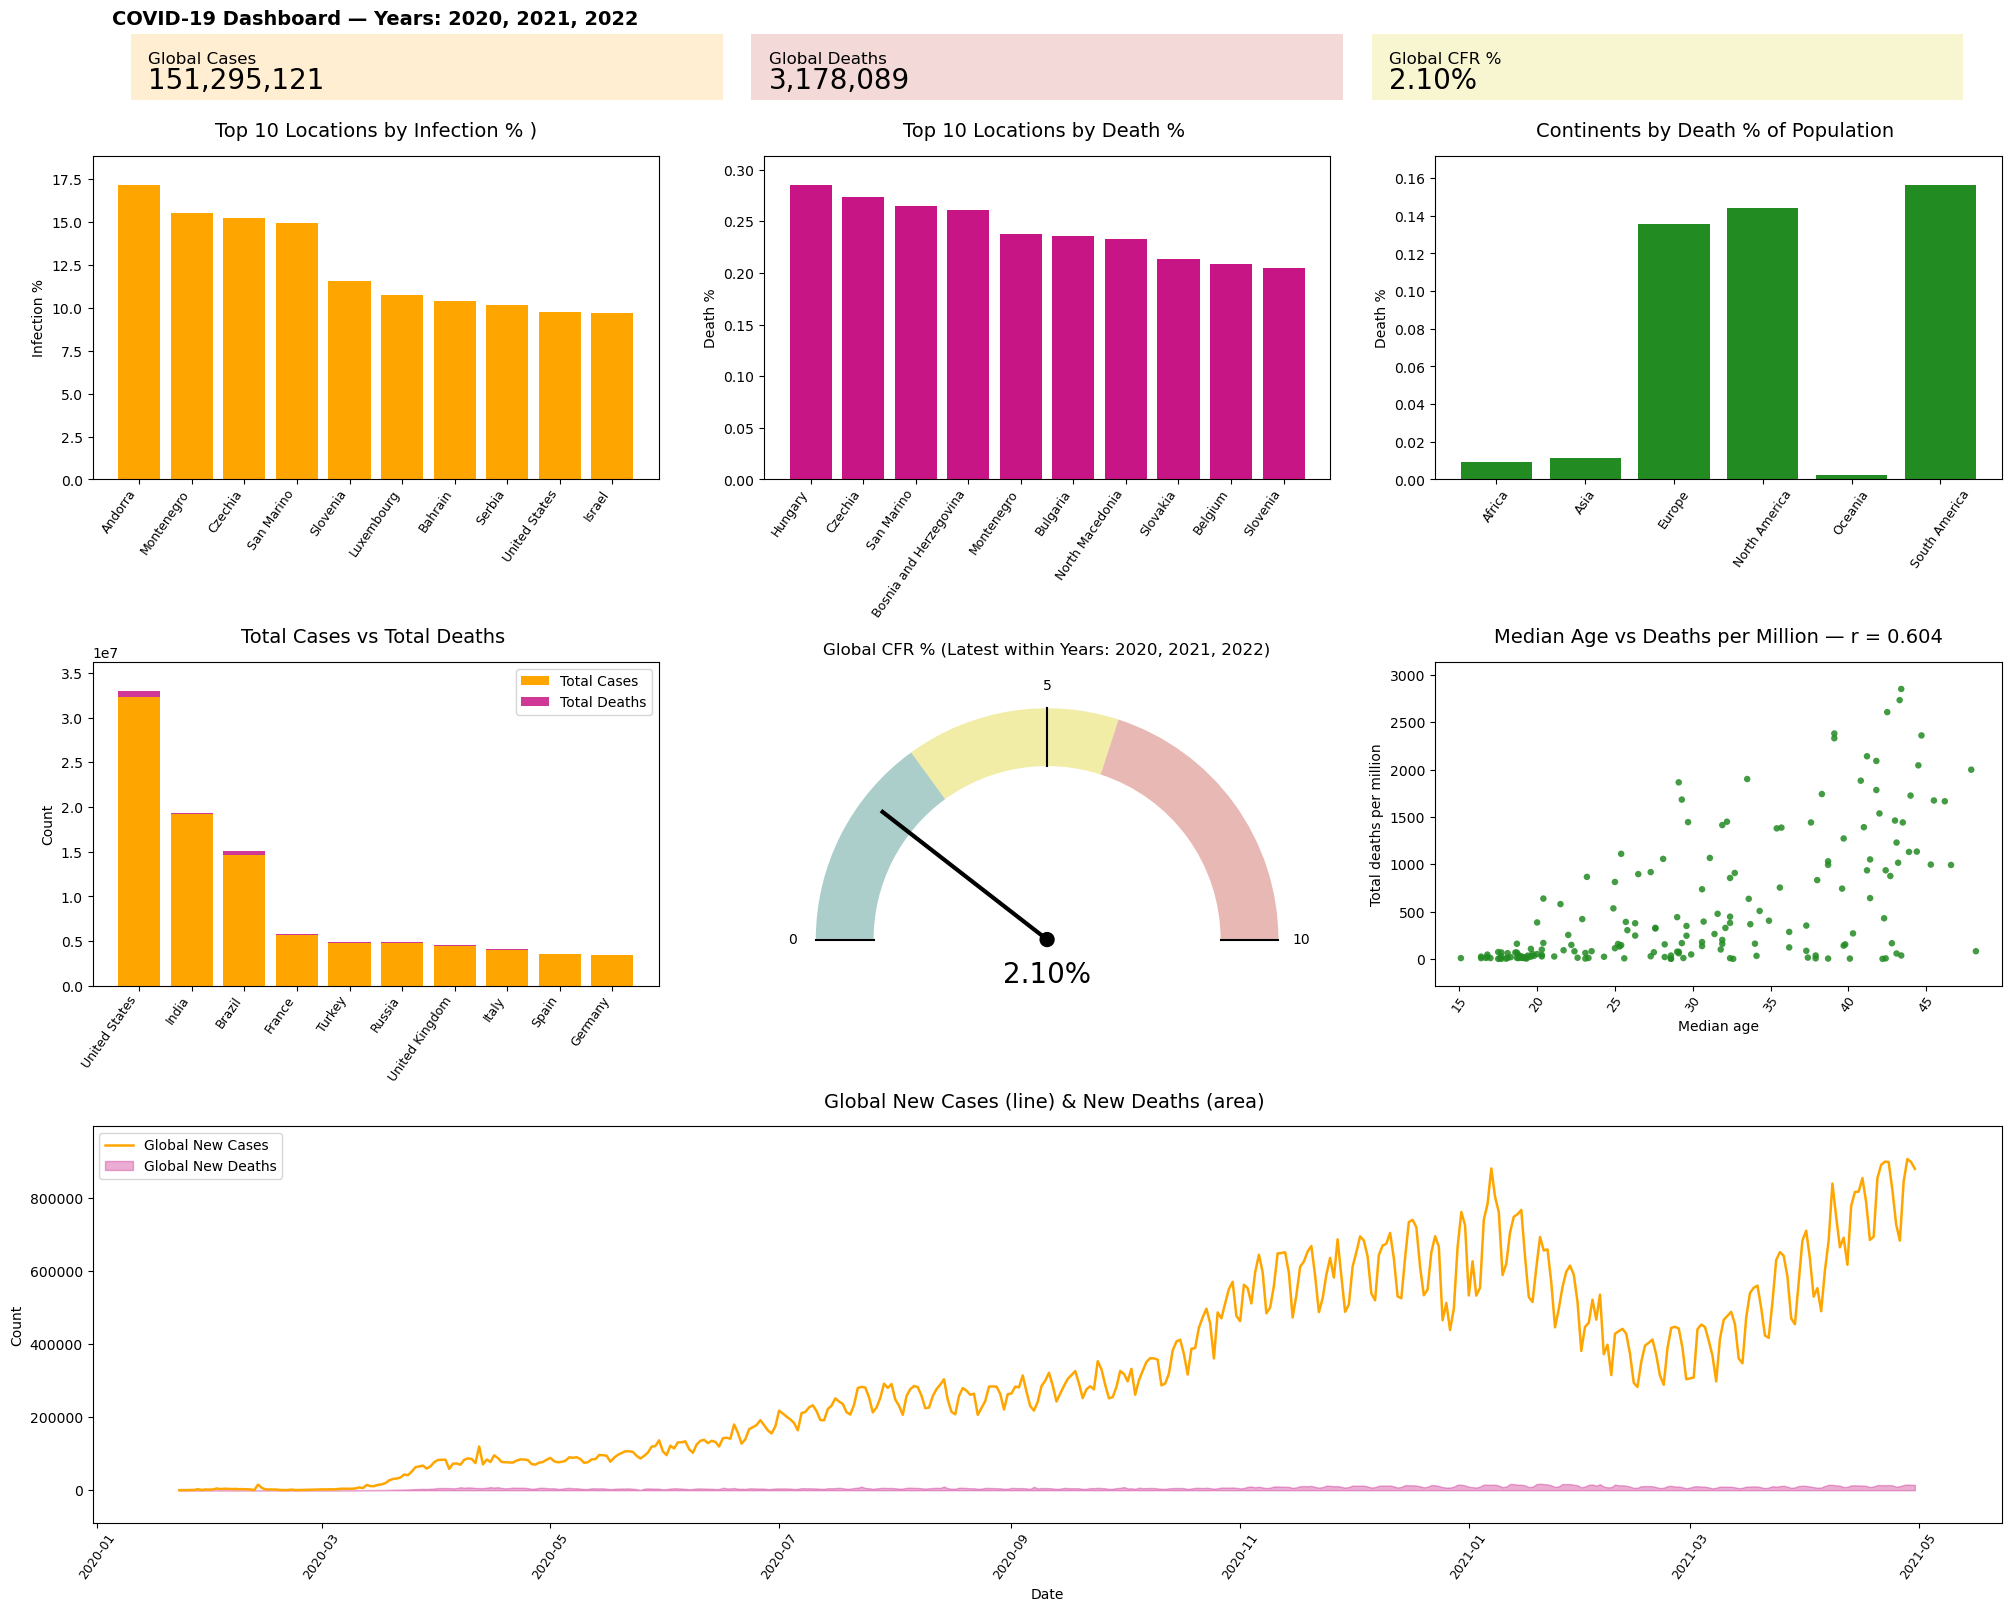

In [1]:
# THEMED COVID-19 DASHBOARD with YEAR FILTER (single figure, saved as JPG)
# - Filters data in SQL by selected YEARS
# - Snapshot uses the latest date *within* the selected years
# - Population comes from CovidDeaths (alias d)
# - Theme loaded from JSON (palette/fonts)
# - Overlap-free layout via constrained_layout
# - Suppresses "findfont" warnings

import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc
from matplotlib.patches import Wedge, Circle, Rectangle

# ---------------------------
# 0) User settings
# ---------------------------
# Choose the years you want included in the dashboard (leave empty list [] for all years)
YEARS = [2020, 2021, 2022]   # <-- EDIT THIS LIST

# Theme JSON + Output path
THEME_JSON_PATH = r"C:\Data\Theme_orange_pink_green.json"  # <-- change if needed
OUT_PATH = r"C:\Users\linke\OneDrive - AL-Hussien bin Abdullah Technical University\Desktop\Current research\Data Analytics portfolio\Covid\Covid_19_dashboard.jpg"

# SQL Server connection (edit if needed)
SQL_DRIVER = "{ODBC Driver 17 for SQL Server}"  # or "{ODBC Driver 18 for SQL Server}"
SQL_SERVER = "SALEEM"
SQL_DB     = "COVID_19"

# ---------------------------
# 1) Suppress font warnings
# ---------------------------
warnings.filterwarnings("ignore", message=".*findfont:.*")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# ---------------------------
# 2) Theme
# ---------------------------
def load_theme(p):
    try:
        with open(p, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return {
            "textClasses": {
                "label":  {"fontSize": 10},
                "callout":{"fontSize": 20},
                "header": {"fontSize": 14},
                "title":  {"fontSize": 12},
            },
            "dataColors": ["#FFA500", "#C71585", "#228B22", "#FF4500", "#FF1493", "#006400"],
            "bad": "#BF372A",
            "neutral": "#D9CA00",
            "good": "#127369",
        }

theme     = load_theme(THEME_JSON_PATH)
label_fs  = theme.get("textClasses", {}).get("label",   {}).get("fontSize", 10)
callout_fs= theme.get("textClasses", {}).get("callout", {}).get("fontSize", 20)
header_fs = theme.get("textClasses", {}).get("header",  {}).get("fontSize", 14)
title_fs  = theme.get("textClasses", {}).get("title",   {}).get("fontSize", 12)
palette   = theme.get("dataColors", ["#FFA500", "#C71585", "#228B22", "#FF4500", "#FF1493", "#006400"])
c_good    = theme.get("good",    "#127369")
c_neutral = theme.get("neutral", "#D9CA00")
c_bad     = theme.get("bad",     "#BF372A")

# Safe, common fonts to avoid warnings
plt.rcParams["font.size"]   = label_fs
plt.rcParams["font.family"] = ["DejaVu Sans", "Arial", "Segoe UI", "sans-serif"]

# ---------------------------
# 3) Year filter helpers
# ---------------------------
def year_clause(years, column="[date]"):
    """Builds an 'AND YEAR([date]) IN (...)' SQL fragment or empty string if years list empty."""
    if not years:
        return ""
    years = [int(y) for y in years]
    inside = ",".join(str(y) for y in sorted(set(years)))
    return f" AND YEAR({column}) IN ({inside}) "

def years_label(years):
    if not years:
        return "All Years"
    return "Years: " + ", ".join(str(y) for y in sorted(set(int(y) for y in years)))

YEAR_FILTER = year_clause(YEARS)
YEAR_LABEL  = years_label(YEARS)

# ---------------------------
# 4) Connect & SQL
# ---------------------------
conn = pyodbc.connect(
    f"DRIVER={SQL_DRIVER};"
    f"SERVER={SQL_SERVER};"
    f"DATABASE={SQL_DB};"
    "Trusted_Connection=Yes;"
)

# Global time series directly aggregated in SQL (filtered by years if provided)
SQL_TS = f"""
SELECT
    [date],
    SUM(new_cases)  AS global_new_cases,
    SUM(new_deaths) AS global_new_deaths
FROM dbo.CovidDeaths
WHERE iso_code NOT LIKE 'OWID_%' {YEAR_FILTER}
GROUP BY [date]
ORDER BY [date];
"""

# Snapshot within selected years:
# 1) Base = deaths filtered by years
# 2) latest_per_loc from Base
# 3) Join Base to Vaccinations and latest_per_loc
SQL_SNAPSHOT = f"""
;WITH base AS (
    SELECT *
    FROM dbo.CovidDeaths
    WHERE iso_code NOT LIKE 'OWID_%' {YEAR_FILTER}
),
latest_per_loc AS (
    SELECT location, MAX([date]) AS latest_date
    FROM base
    GROUP BY location
)
SELECT
    d.iso_code,
    d.continent,
    d.location,
    d.[date],
    d.total_cases,
    d.total_deaths,
    d.total_cases_per_million,
    d.total_deaths_per_million,
    d.population,               -- population is in CovidDeaths
    v.median_age,
    v.population_density,
    v.stringency_index,
    CASE WHEN d.population > 0 AND d.total_cases IS NOT NULL
         THEN d.total_cases * 100.0 / d.population END AS infection_pct,
    CASE WHEN d.population > 0 AND d.total_deaths IS NOT NULL
         THEN d.total_deaths * 100.0 / d.population END AS death_pct,
    CASE WHEN d.total_cases IS NOT NULL AND d.total_cases > 0
         THEN d.total_deaths * 100.0 / d.total_cases END AS cfr_pct
FROM base d
JOIN dbo.CovidVaccinations v
  ON d.iso_code = v.iso_code AND d.[date] = v.[date]
JOIN latest_per_loc l
  ON d.location = l.location AND d.[date] = l.latest_date;
"""

# ---------------------------
# 5) Read data
# ---------------------------
df_ts   = pd.read_sql(SQL_TS,       conn)
df_snap = pd.read_sql(SQL_SNAPSHOT, conn)
conn.close()

# Types & trims
df_ts["date"] = pd.to_datetime(df_ts["date"])
if "date" in df_snap.columns:
    df_snap["date"] = pd.to_datetime(df_snap["date"])
for col in ("iso_code", "location", "continent"):
    if col in df_snap.columns:
        df_snap[col] = df_snap[col].astype(str).str.strip()

# ---------------------------
# 6) Derivations (handle empty gracefully)
# ---------------------------
TOP_N = 10

def safe_sum(df, col):
    return float(df[col].sum(skipna=True)) if (col in df.columns and len(df) > 0) else np.nan

tot_cases  = safe_sum(df_snap, "total_cases")
tot_deaths = safe_sum(df_snap, "total_deaths")
tot_pop    = safe_sum(df_snap, "population")

global_cfr_pct       = (tot_deaths / tot_cases * 100.0) if (isinstance(tot_cases, (int,float)) and tot_cases > 0) else np.nan
global_infection_pct = (tot_cases / tot_pop * 100.0)    if (isinstance(tot_pop,   (int,float)) and tot_pop   > 0) else np.nan

top_infection = (df_snap.dropna(subset=["infection_pct"])
                 .sort_values("infection_pct", ascending=False)
                 .head(TOP_N)[["location","infection_pct"]]) if len(df_snap) else pd.DataFrame(columns=["location","infection_pct"])

top_death = (df_snap.dropna(subset=["death_pct"])
             .sort_values("death_pct", ascending=False)
             .head(TOP_N)[["location","death_pct"]]) if len(df_snap) else pd.DataFrame(columns=["location","death_pct"])

cont = (df_snap.groupby("continent", dropna=False)
               .agg(deaths=("total_deaths","sum"),
                    population=("population","sum"))
               .reset_index()) if len(df_snap) else pd.DataFrame(columns=["continent","deaths","population"])
if len(cont):
    cont["death_pct"] = np.where(cont["population"]>0, cont["deaths"]*100.0/cont["population"], np.nan)
    cont["continent"] = cont["continent"].fillna("Unspecified")

stack_df = (df_snap.dropna(subset=["total_cases"])
            .sort_values("total_cases", ascending=False)
            .head(TOP_N)[["location","total_cases","total_deaths"]]).fillna(0.0) if len(df_snap) else pd.DataFrame(columns=["location","total_cases","total_deaths"])

scatter_df = df_snap[["median_age", "total_deaths_per_million"]].dropna() if len(df_snap) else pd.DataFrame(columns=["median_age","total_deaths_per_million"])
r = (np.corrcoef(scatter_df["median_age"], scatter_df["total_deaths_per_million"])[0,1]
     if len(scatter_df) > 2 else np.nan)

# ---------------------------
# 7) Dashboard (single figure, no overlap)
# ---------------------------
fig = plt.figure(figsize=(20, 16), constrained_layout=True)
gs  = fig.add_gridspec(nrows=4, ncols=3, height_ratios=[0.32, 1.10, 1.10, 1.35])

# Axes
ax_cards   = fig.add_subplot(gs[0, :])
ax_inf     = fig.add_subplot(gs[1, 0])
ax_death   = fig.add_subplot(gs[1, 1])
ax_cont    = fig.add_subplot(gs[1, 2])
ax_stack   = fig.add_subplot(gs[2, 0])
ax_gauge   = fig.add_subplot(gs[2, 1])
ax_scatter = fig.add_subplot(gs[2, 2])
ax_line    = fig.add_subplot(gs[3, :])

def set_axis_style(ax, title):
    ax.set_title(title, fontsize=header_fs, pad=14)

def pad_axes(*axes):
    for ax in axes:
        ax.tick_params(axis="x", labelrotation=55, labelsize=max(8, label_fs - 1), pad=2)
        ax.margins(y=0.10)

# ---------- KPI Cards ----------
ax_cards.axis("off")
ax_cards.set_xlim(0, 1); ax_cards.set_ylim(0, 1)
ax_cards.text(0.01, 0.94, f"COVID-19 Dashboard — {YEAR_LABEL}",
              fontsize=header_fs, weight="bold")

def draw_kpi_card(ax, xy, w, h, title, value, bg_color, txt_color="black"):
    x, y = xy
    ax.add_patch(Rectangle((x, y), w, h, linewidth=0, facecolor=bg_color, alpha=0.18))
    ax.text(x + 0.03*w, y + 0.62*h, title, fontsize=title_fs, color=txt_color, va="center")
    ax.text(x + 0.03*w, y + 0.30*h, value, fontsize=callout_fs, color=txt_color, va="center")

def fmt_int(x):
    return "N/A" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{int(round(x)):,}"

def fmt_pct(x):
    return "N/A" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{x:.2f}%"

card_w, card_h = 0.31, 0.70
draw_kpi_card(ax_cards, (0.02,  0.14), card_w, card_h, "Global Cases",  fmt_int(tot_cases),  palette[0])
draw_kpi_card(ax_cards, (0.345, 0.14), card_w, card_h, "Global Deaths", fmt_int(tot_deaths), c_bad)
draw_kpi_card(ax_cards, (0.67,  0.14), card_w, card_h, "Global CFR %",  fmt_pct(global_cfr_pct), c_neutral)

# ---------- Bar: Top infection % ----------
if len(top_infection):
    ax_inf.bar(np.arange(len(top_infection)), top_infection["infection_pct"].values, color=palette[0])
    ax_inf.set_xticks(np.arange(len(top_infection)))
    ax_inf.set_xticklabels(top_infection["location"].values, ha="right")
    ax_inf.set_ylabel("Infection %")
    set_axis_style(ax_inf, f"Top {len(top_infection)} Locations by Infection % )")
else:
    ax_inf.axis("off"); ax_inf.text(0.5, 0.5, "No data for selected years", ha="center", va="center", fontsize=title_fs)

# ---------- Bar: Top death % ----------
if len(top_death):
    ax_death.bar(np.arange(len(top_death)), top_death["death_pct"].values, color=palette[1])
    ax_death.set_xticks(np.arange(len(top_death)))
    ax_death.set_xticklabels(top_death["location"].values, ha="right")
    ax_death.set_ylabel("Death %")
    set_axis_style(ax_death, f"Top {len(top_death)} Locations by Death % ")
else:
    ax_death.axis("off"); ax_death.text(0.5, 0.5, "No data for selected years", ha="center", va="center", fontsize=title_fs)

# ---------- Bar: Continents death % ----------
if len(cont):
    ax_cont.bar(np.arange(len(cont)), cont["death_pct"].values, color=palette[2])
    ax_cont.set_xticks(np.arange(len(cont)))
    ax_cont.set_xticklabels(cont["continent"].values)
    ax_cont.set_ylabel("Death %")
    set_axis_style(ax_cont, f"Continents by Death % of Population ")
else:
    ax_cont.axis("off"); ax_cont.text(0.5, 0.5, "No data for selected years", ha="center", va="center", fontsize=title_fs)

# ---------- Stacked: Cases vs Deaths ----------
if len(stack_df):
    x = np.arange(len(stack_df))
    ax_stack.bar(x, stack_df["total_cases"].values,  label="Total Cases",  color=palette[0])
    ax_stack.bar(x, stack_df["total_deaths"].values, bottom=stack_df["total_cases"].values,
                 label="Total Deaths", color=palette[1], alpha=0.85)
    ax_stack.set_xticks(x)
    ax_stack.set_xticklabels(stack_df["location"].values, ha="right")
    ax_stack.set_ylabel("Count")
    ax_stack.legend(fontsize=label_fs)
    set_axis_style(ax_stack, f"Total Cases vs Total Deaths ")
else:
    ax_stack.axis("off"); ax_stack.text(0.5, 0.5, "No data for selected years", ha="center", va="center", fontsize=title_fs)

# ---------- Gauge: Global CFR % ----------
def draw_gauge(ax, value, vmin=0.0, vmax=10.0, title="Global CFR %"):
    ax.set_aspect("equal"); ax.axis("off")
    bands = [(0, 3, c_good), (3, 6, c_neutral), (6, vmax, c_bad)]
    for a, b, col in bands:
        th1 = 180 - (a - vmin)/(vmax-vmin)*180
        th2 = 180 - (b - vmin)/(vmax-vmin)*180
        ax.add_patch(Wedge((0,0), 1.0, th2, th1, width=0.25, facecolor=col, alpha=0.35))
    if value is None or (isinstance(value, float) and np.isnan(value)):
        theta = 180.0; label = "N/A"
    else:
        v = max(vmin, min(float(value), vmax))
        theta = 180.0 - (v - vmin) / (vmax - vmin) * 180.0
        label = f"{value:.2f}%"
    ax.plot([0, 0.9*np.cos(np.radians(theta))], [0, 0.9*np.sin(np.radians(theta))], linewidth=3, color="black")
    ax.add_patch(Circle((0,0), 0.03, color="black"))
    for ang, txt in [(180,"0"), (90,"5"), (0,"10")]:
        ax.plot([0.75*np.cos(np.radians(ang)), 1.0*np.cos(np.radians(ang))],
                [0.75*np.sin(np.radians(ang)), 1.0*np.sin(np.radians(ang))], color="black")
        ax.text(1.1*np.cos(np.radians(ang)), 1.1*np.sin(np.radians(ang)), txt, ha="center", va="center", fontsize=label_fs)
    ax.set_xlim(-1.2, 1.2); ax.set_ylim(-0.2, 1.2)
    ax.set_title(f"{title} (Latest within {YEAR_LABEL})", fontsize=title_fs)
    ax.text(0, -0.15, label, ha="center", va="center", fontsize=callout_fs)

draw_gauge(ax_gauge, global_cfr_pct, vmin=0, vmax=10)

# ---------- Scatter: Median age vs deaths/million ----------
if len(scatter_df):
    ax_scatter.scatter(scatter_df["median_age"], scatter_df["total_deaths_per_million"],
                       s=22, color=palette[2], alpha=0.85, edgecolor="none")
    ax_scatter.set_xlabel("Median age")
    ax_scatter.set_ylabel("Total deaths per million")
    sc_title = f"Median Age vs Deaths per Million"
    if not np.isnan(r): sc_title += f" — r = {r:.3f}"
    set_axis_style(ax_scatter, sc_title)
else:
    ax_scatter.axis("off"); ax_scatter.text(0.5, 0.5, "No data for selected years", ha="center", va="center", fontsize=title_fs)

# ---------- Line + Area: New cases & new deaths ----------
if len(df_ts):
    df_ts["date"] = pd.to_datetime(df_ts["date"])
    ax_line.plot(df_ts["date"], df_ts["global_new_cases"],  label="Global New Cases",  color=palette[0], linewidth=1.8)
    ax_line.fill_between(df_ts["date"], df_ts["global_new_deaths"], alpha=0.35, label="Global New Deaths", color=palette[1])
    ax_line.set_xlabel("Date")
    ax_line.set_ylabel("Count")
    ax_line.legend(fontsize=label_fs)
    set_axis_style(ax_line, f"Global New Cases (line) & New Deaths (area) ")
else:
    ax_line.axis("off"); ax_line.text(0.5, 0.5, "No data for selected years", ha="center", va="center", fontsize=title_fs)

# Final padding on busy axes
pad_axes(ax_inf, ax_death, ax_cont, ax_stack, ax_scatter, ax_line)

# ---------------------------
# 8) Save as JPG
# ---------------------------
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
fig.savefig(OUT_PATH, format="jpg", dpi=220, bbox_inches="tight")
print(f"Saved: {OUT_PATH}")
plt.show()
